In [1]:
import tejapi 
import pandas as pd
import numpy as np
tejapi.ApiConfig.api_key = 'your_key'
import datetime
import matplotlib.pyplot as plt

In [2]:
stk_info = pd.read_csv('TW50.csv',engine='python')
stk_nums = stk_info['成份股'].apply(lambda x: str(x).split(' ')[0])
# 撈取財務資料
zz = pd.DataFrame()
for code in stk_nums:
    zz = zz.append(tejapi.get('TWN/AIM1A'
                ,coid=code
                ,paginate=True,chinese_column_name=True
                ,opts= {'pivot':True}
                )).reset_index(drop=True)
    print(code)

1101
1102
1216
1301
1303
1326
1402
2002
2105
2207
2303
2308
2317
2327
2330
2357
2379
2382
2395
2408
2412
2454
2474
2633
2801
2880
2881
2882
2883
2884
2885
2886
2887
2890
2891
2892
2912
3008
3034
3045
3711
4904
4938
5871
5876
5880
6415
6505
6669
9910


In [3]:
zz

,公司代碼,財報年月,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,其他應收款,...,財報發布日,財報類別（1個別2個體3合併）,財報年月起日,財報年月迄日,市場別,交易所主產業代碼,交易所子產業代碼,TEJ主產業代碼,TEJ子產業代碼,財報附註TEJ是否完成Y/N
0,1101,2000-12-01 00:00:00+00:00,2090427.0,2034358.0,NaN,NaN,NaN,NaN,4845152.0,372794.0,...,None,None,None,None,None,None,None,None,None,None
1,1101,2001-12-01 00:00:00+00:00,1912095.0,582788.0,NaN,NaN,NaN,NaN,5532510.0,378339.0,...,None,None,None,None,None,None,None,None,None,None
2,1101,2002-12-01 00:00:00+00:00,4985267.0,3950592.0,NaN,NaN,NaN,NaN,6815253.0,459579.0,...,None,None,None,None,None,None,None,None,None,None
3,1101,2003-12-01 00:00:00+00:00,4818795.0,2917374.0,NaN,NaN,NaN,NaN,6678565.0,512850.0,...,None,None,None,None,None,None,None,None,None,None
4,1101,2004-12-01 00:00:00+00:00,3978093.0,5844529.0,NaN,NaN,NaN,NaN,7219010.0,11670.0,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,9910,2019-12-01 00:00:00+00:00,4038083.0,0.0,0,0.0,0,0,6638905.0,431595.0,...,None,None,None,None,None,None,None,None,None,None
2946,9910,2020-03-01 00:00:00+00:00,4836056.0,0.0,NaN,NaN,NaN,0,6098455.0,429315.0,...,None,None,None,None,None,None,None,None,None,None
2947,9910,2020-06-01 00:00:00+00:00,2974142.0,0.0,0,0.0,0,0,5714248.0,359072.0,...,None,None,None,None,None,None,None,None,None,None
2948,9910,2020-09-01 00:00:00+00:00,3844304.0,0.0,0,0.0,0,0,7013897.0,458571.0,...,None,None,None,None,None,None,None,None,None,None


In [4]:
# 自原始資料挑選特定欄位
zz1 = zz[['公司代碼','財報年月','歸屬母公司淨利（損）','每股盈餘','常續性稅後淨利','普通股每股現金股利（盈餘及公積）','流動比率','當季季底P/E','當季季底P/B','流動資產','流動負債','非流動負債']]
# 創立儲存結果的dataframe
result = pd.DataFrame()
for stk_num in stk_nums:
    # 撈取股價年資料
    stock_y = tejapi.get('TWN/APRCY'
                    ,coid=stk_num
                    ,paginate=True,chinese_column_name=True
                    )
    z1 = zz1[zz1['公司代碼']==stk_num]
    if z1.size!= 0:
        # 季資料轉年資料
        # last 用於判斷 在相同年份下以最後一筆資料為主，TEJ資料庫內建累積財報，故以最新一期的財報資料
        z1 = z1.resample('Y',on='財報年月').last()
        # 股價資料
        z1 = pd.merge(z1.reset_index(drop=True),stock_y[['年月日','收盤價(元)_年']],left_on='財報年月',right_on='年月日')
        z1.rename(columns={'收盤價(元)_年':'close'},inplace=True)

        # 條件1：年營收大於市場平均值的公司
        # 台灣50成分股基本上營收沒問題因此這邊先將此條件剔除
        
        # 條件2：過去5年皆有盈餘
        z1['earning'] = np.where(z1['常續性稅後淨利']>0,1,0)
        z1['earning_continue'] = z1['earning'].rolling(5).sum()
        z1['condition_2'] = np.where(z1['earning_continue']==5,1,0)

        # 條件3：過去2年皆有支付現金股利
        z1['cash_dividend'] = np.where(z1['普通股每股現金股利（盈餘及公積）']>0,1,0)
        z1['cash_dividends'] = z1['cash_dividend'].rolling(2).sum()
        z1['condition_3'] = np.where(z1['cash_dividends']==2,1,0)

        # 條件4：流動比率>200%
        z1['condition_4'] = np.where(z1['流動比率']>200,1,0)

        # 條件5：流動資產-長期負債>0
        z1['condition_5'] = np.where((z1['流動資產']-z1['流動負債']-z1['非流動負債'])>0,1,0)

        # 條件6：abs【(近3年平均稅後淨利-近5年平均稅後淨利)/近5年平均稅後淨利】 >0.33
        z1['近3年平均稅後淨利'] = z1['歸屬母公司淨利（損）'].rolling(3).mean()
        z1['近5年平均稅後淨利'] = z1['歸屬母公司淨利（損）'].rolling(5).mean()
        z1['condition_6'] = np.where(abs((z1['近3年平均稅後淨利']-z1['近5年平均稅後淨利'])/z1['近5年平均稅後淨利'])>0.33,1,0)

        # 條件7：PER (當年年底收盤價/近3年平均每股盈餘) <= 近3年PER之平均
        z1['近3年平均EPS'] = z1['每股盈餘'].rolling(3).mean()
        z1['近3年平均PER'] = z1['當季季底P/E'].rolling(3).mean()
        z1['PER1'] = z1['close']/z1['近3年平均EPS']
        z1['condition_7'] = np.where(z1['PER1']<=z1['近3年平均PER'],1,0)

        # 條件8：PER(以近4季每股盈餘計算)*PBR <= 近三年PER*PBR平均
        z1['PEPB'] = z1['當季季底P/E']*z1['當季季底P/B']
        z1['mean_PEPB_3'] = z1['PEPB'].rolling(3).mean()
        z1['condition_8'] = np.where(z1['PEPB']<=z1['mean_PEPB_3'],1,0)

        # 計算總分
        z1['score'] = z1['condition_2']+z1['condition_3']+z1['condition_4']+z1['condition_5']+z1['condition_6']+z1['condition_7']+z1['condition_8']
        result = result.append(z1).reset_index(drop=True)
        print(stk_num)

1101
1102
1216
1301
1303
1326
1402
2002
2105
2207
2303
2308
2317
2327
2330
2357
2379
2382
2395
2408
2412
2454
2474
2633
2801
2880
2881
2882
2883
2884
2885
2886
2887
2890
2891
2892
2912
3008
3034
3045
3711
4904
4938
5871
5876
5880
6415
6505
6669
9910


In [5]:
result

,公司代碼,財報年月,歸屬母公司淨利（損）,每股盈餘,常續性稅後淨利,普通股每股現金股利（盈餘及公積）,流動比率,當季季底P/E,當季季底P/B,流動資產,...,近5年平均稅後淨利,condition_6,近3年平均EPS,近3年平均PER,PER1,condition_7,PEPB,mean_PEPB_3,condition_8,score
0,1101,2000-12-01 00:00:00+00:00,1081640.0,0.46,-1274310.0,0.00,89.77,NaN,0.91,1.64748e+07,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0,0
1,1101,2001-12-01 00:00:00+00:00,190575.0,0.05,-1661790.0,0.00,82.01,NaN,0.47,1.38935e+07,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0,0
2,1101,2002-12-01 00:00:00+00:00,286737.0,0.02,1021253.0,0.10,69.77,25.50,0.54,2.04693e+07,...,NaN,0,0.176667,NaN,59.150943,0,13.7700,NaN,0,0
3,1101,2003-12-01 00:00:00+00:00,1762182.0,0.60,53212.0,0.35,95.36,799.16,0.87,1.93176e+07,...,NaN,0,0.223333,NaN,74.776119,0,695.2692,NaN,0,1
4,1101,2004-12-01 00:00:00+00:00,4421526.0,1.59,5007664.0,0.70,139.54,11.04,1.06,2.37754e+07,...,1548532.0,1,0.736667,278.566667,28.371041,1,11.7024,240.247200,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,9910,2016-12-01 00:00:00+00:00,4453286.0,6.67,4768584.0,5.20,161.53,11.32,5.81,1.45736e+07,...,3150509.6,0,6.370000,12.693333,18.916797,0,65.7692,80.996667,1,3
922,9910,2017-12-01 00:00:00+00:00,4395129.0,6.58,4842897.0,5.00,152.61,14.06,6.62,1.46856e+07,...,3693517.6,0,6.786667,13.743333,19.965619,0,93.0772,93.366300,1,3
923,9910,2018-12-01 00:00:00+00:00,5262739.0,7.88,5906142.0,6.70,168.91,13.49,7.33,1.72637e+07,...,4287257.8,0,7.043333,12.956667,24.917179,0,98.8817,85.909367,0,3
924,9910,2019-12-01 00:00:00+00:00,6230779.0,8.48,7061441.0,4.00,133.63,14.56,8.62,1.98003e+07,...,4915983.4,0,7.646667,14.036667,25.501308,0,125.5072,105.822033,0,2


In [6]:
return_=pd.DataFrame()
dates = result['財報年月'].astype(str).apply(lambda x: x.split(' ')[0]).unique()
step = 0.2
for date in dates:
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])
    day = 31
    date31 = str(year)+'-'+str(month)+'-'+str(day)
    ret = [date31]
    for n in np.arange(0,1,step):
        # 設定日期
        pf = result[result['財報年月']==date].sort_values(by='score',ascending=False).reset_index(drop=True)
        # 設立組距
        first = round(len(pf)*(n))
        last = round(len(pf)*(n+step))
        # 儲存選出來之公司
        pf_H = pf.loc[first:last]['公司代碼'].to_list()
        # 將買進日期設在季底+90日
        buy_date = datetime.datetime(year,month,day)+ datetime.timedelta(90)
        sell_date = buy_date + datetime.timedelta(365) 
        # 自 tejapi撈取股價資料，日期設定為 buy_date至 sell_date(含)
        print('getting data')
        data = tejapi.get('TWN/APRCD1',coid  =pf_H ,paginate = True,mdate={'gte':buy_date,'lte':sell_date})
        # 儲存買賣價格
        start = data['mdate'].unique()[0]
        end = data['mdate'].unique()[-1]
        buy_coid = data['coid'][data['mdate']==start]
        sell_coid = data['coid'][data['mdate']==end]
        coid = list(set(buy_coid) & set(sell_coid))
        buy_price = data[(data['mdate']==start) & (buy_coid.isin(coid))]['close_adj'].values
        sell_price = data[(data['mdate']==end) & (sell_coid.isin(coid))]['close_adj'].values
        if len(buy_price)==len(sell_price):
            # 計算報酬率
            print('calculating return')
            q1_ret = ((sell_price-buy_price)/buy_price)*100
            w = 1/len(pf_H) # 等權重
            q1_wret = w*q1_ret # 加權平均報酬
            fee = round((0.1425*2*len(pf_H) + 0.3*1),2)
            #
            ret.append(round(sum(q1_wret)-fee,2))
    if len(ret)==6:
        rets = np.reshape(np.array(ret),(1,6)).tolist()
        res = pd.DataFrame(data=rets,columns=['Date','p1_return','p2_return','p3_return','p4_return','p5_return'])
        return_ = return_.append(res).reset_index(drop=True)
    print(return_)

getting data
calculating return
getting data
calculating return
getting data
calculating return
getting data
calculating return
getting data
calculating return
         Date p1_return p2_return p3_return p4_return p5_return
0  2000-12-31      53.2     -2.47      2.81      8.47      5.01
getting data
calculating return
getting data
calculating return
getting data
calculating return
getting data
calculating return
getting data
calculating return
         Date p1_return p2_return p3_return p4_return p5_return
0  2000-12-31      53.2     -2.47      2.81      8.47      5.01
1  2001-12-31    -22.97    -29.02     -6.78     17.29    -30.62
getting data
calculating return
getting data
calculating return
getting data
calculating return
getting data
calculating return
getting data
calculating return
         Date p1_return p2_return p3_return p4_return p5_return
0  2000-12-31      53.2     -2.47      2.81      8.47      5.01
1  2001-12-31    -22.97    -29.02     -6.78     17.29    -30.62
2  2002-

calculating return
getting data
calculating return
getting data
calculating return
getting data
calculating return
getting data
calculating return
          Date p1_return p2_return p3_return p4_return p5_return
0   2000-12-31      53.2     -2.47      2.81      8.47      5.01
1   2001-12-31    -22.97    -29.02     -6.78     17.29    -30.62
2   2002-12-31     29.94     87.79     66.38      51.9      65.6
3   2003-12-31      2.11      4.96      2.66     -6.26     -2.28
4   2004-12-31     64.43     27.43      3.85      8.46     -3.91
5   2005-12-31     34.78     14.94     18.52      20.0       7.6
6   2006-12-31      6.36     17.89     38.92     20.51     21.33
7   2007-12-31    -26.34    -43.05     -45.7    -39.61    -46.19
8   2008-12-31     66.56     41.87     53.15     41.22      49.3
9   2009-12-31     33.15     11.34     26.91     18.99     14.64
10  2010-12-31     -3.78     -5.42     10.89     23.57    -10.07
11  2011-12-31      7.37     20.74      6.89     14.39     21.07
12  2012

calculating return
getting data
calculating return
getting data
calculating return
getting data
calculating return
          Date p1_return p2_return p3_return p4_return p5_return
0   2000-12-31      53.2     -2.47      2.81      8.47      5.01
1   2001-12-31    -22.97    -29.02     -6.78     17.29    -30.62
2   2002-12-31     29.94     87.79     66.38      51.9      65.6
3   2003-12-31      2.11      4.96      2.66     -6.26     -2.28
4   2004-12-31     64.43     27.43      3.85      8.46     -3.91
5   2005-12-31     34.78     14.94     18.52      20.0       7.6
6   2006-12-31      6.36     17.89     38.92     20.51     21.33
7   2007-12-31    -26.34    -43.05     -45.7    -39.61    -46.19
8   2008-12-31     66.56     41.87     53.15     41.22      49.3
9   2009-12-31     33.15     11.34     26.91     18.99     14.64
10  2010-12-31     -3.78     -5.42     10.89     23.57    -10.07
11  2011-12-31      7.37     20.74      6.89     14.39     21.07
12  2012-12-31     34.07     12.12      

In [7]:
return_

,Date,p1_return,p2_return,p3_return,p4_return,p5_return
0,2000-12-31,53.2,-2.47,2.81,8.47,5.01
1,2001-12-31,-22.97,-29.02,-6.78,17.29,-30.62
2,2002-12-31,29.94,87.79,66.38,51.9,65.6
3,2003-12-31,2.11,4.96,2.66,-6.26,-2.28
4,2004-12-31,64.43,27.43,3.85,8.46,-3.91
5,2005-12-31,34.78,14.94,18.52,20.0,7.6
6,2006-12-31,6.36,17.89,38.92,20.51,21.33
7,2007-12-31,-26.34,-43.05,-45.7,-39.61,-46.19
8,2008-12-31,66.56,41.87,53.15,41.22,49.3
9,2009-12-31,33.15,11.34,26.91,18.99,14.64


In [14]:
# 以投資台灣50指數做為比較基準
tw0050 = tejapi.get('TWN/APRCD1',coid ='TRI50' ,paginate = True)
benchmark = pd.DataFrame({
    'close_start':tw0050.resample('Y',on='mdate').first()['close_adj'],
    'close_end':tw0050.resample('Y',on='mdate').last()['close_adj']
})
benchmark['mdate'] = benchmark.index
benchmark['mdate'] = benchmark['mdate'].astype(str).apply(lambda x:x.split()[0])
benchmark['return'] = (benchmark['close_end']-benchmark['close_start'])/benchmark['close_start']
benchmark['bm_return']  = (benchmark['return']+1).cumprod()
benchmark

,close_start,close_end,mdate,return,bm_return
mdate,,,,,
2002-12-31 00:00:00+00:00,4060.93,3308.03,2002-12-31,-0.185401,0.814599
2003-12-31 00:00:00+00:00,3356.61,4666.88,2003-12-31,0.390355,1.132582
2004-12-31 00:00:00+00:00,4796.17,4928.25,2004-12-31,0.027539,1.163772
2005-12-31 00:00:00+00:00,4920.74,5456.76,2005-12-31,0.108931,1.290542
2006-12-31 00:00:00+00:00,5391.40,6598.88,2006-12-31,0.223964,1.579578
2007-12-31 00:00:00+00:00,6690.82,7356.48,2007-12-31,0.099489,1.736727
2008-12-31 00:00:00+00:00,7157.74,4197.46,2008-12-31,-0.413577,1.018456
2009-12-31 00:00:00+00:00,4321.75,7303.38,2009-12-31,0.689913,1.721102
2010-12-31 00:00:00+00:00,7329.89,8259.84,2010-12-31,0.126871,1.939460


In [15]:
cum_ret = return_[return_['Date'].isin(benchmark['mdate'])][['p1_return','p2_return','p3_return','p4_return','p5_return']].astype(float).apply(lambda x:(x*0.01+1).cumprod(),axis=0).reset_index(drop=True)
cum_ret['bm_return'] = benchmark[benchmark['mdate'].isin(return_['Date'])]['bm_return'].reset_index(drop=True)
cum_ret

,p1_return,p2_return,p3_return,p4_return,p5_return,bm_return
0,1.299400,1.877900,1.663800,1.519000,1.656000,0.814599
1,1.326817,1.971044,1.708057,1.423911,1.618243,1.132582
2,2.181686,2.511701,1.773817,1.544373,1.554970,1.163772
3,2.940476,2.886949,2.102328,1.853248,1.673148,1.290542
4,3.127490,3.403425,2.920554,2.233349,2.030030,1.579578
5,2.303709,1.938250,1.585861,1.348720,1.092359,1.736727
6,3.837058,2.749796,2.428746,1.904662,1.630892,1.018456
7,5.109043,3.061623,3.082322,2.266357,1.869655,1.721102
8,4.915921,2.895683,3.417987,2.800538,1.681381,1.939460
9,5.278225,3.496247,3.653486,3.203535,2.035647,1.631646


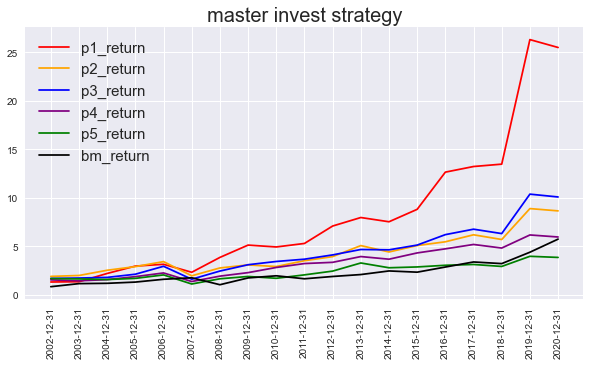

In [16]:
plt.style.use('seaborn')
plt.figure(figsize=(10,5))
plt.xticks(rotation = 90)
plt.title('master invest strategy',fontsize = 20)
date = return_[return_['Date'].isin(benchmark['mdate'])]['Date']
plt.plot(date,cum_ret.p1_return,color ='red',label='p1_return')
plt.plot(date,cum_ret.p2_return,color ='orange',label='p2_return')
plt.plot(date,cum_ret.p3_return,color ='blue',label='p3_return')
plt.plot(date,cum_ret.p4_return,color ='purple',label='p4_return')
plt.plot(date,cum_ret.p5_return,color ='green',label='p5_return')
plt.plot(date,cum_ret.bm_return,color = 'black',label='bm_return')
plt.legend(fontsize = 15)

In [17]:
return_['bm_return'] = benchmark[benchmark['mdate'].isin(return_['Date'])]['return'].reset_index(drop=True)
return_['bm_return'] = return_['bm_return']*100
Ratio = pd.DataFrame()
for col in cum_ret.columns:
    ##年化報酬率
    cagr = (cum_ret[col].values[-1]) ** (1/len(cum_ret)) -1
    ##年化標準差
    std = return_[col].astype(float).std()
    ##Sharpe Ratio(假設無風險利率為1%)
    sharpe_ratio = (cagr-0.01)/(std*0.01)
    ##最大回撤
    roll_max = cum_ret[col].cummax()
    monthly_dd =cum_ret[col]/roll_max - 1.0
    max_dd = monthly_dd.cummin()
    ##表格
    ratio = np.reshape(np.round(np.array([100*cagr, std, sharpe_ratio, 100*max_dd.values[-1]]),2),(1,4))
    Ratio = Ratio.append(pd.DataFrame(index=[col], 
      columns=['年化報酬率(%)', '年化標準差(%)', '夏普比率', '期間最大回撤(%)'], 
      data = ratio))

In [18]:
Ratio.T

,p1_return,p2_return,p3_return,p4_return,p5_return,bm_return
年化報酬率(%),18.59,12.02,12.93,9.84,7.33,9.62
年化標準差(%),30.98,28.08,25.57,18.96,25.46,24.15
夏普比率,0.57,0.39,0.47,0.47,0.25,0.36
期間最大回撤(%),-26.34,-43.05,-45.70,-39.61,-46.19,-41.36
